In [1]:
# import tensorflow as tf

# print(tf.__version__)

In [2]:
# import os
# os.environ.get("tf_upgrade_v2")

In [3]:
# !tf_upgrade_v2 \
#   --infile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan.py \
#   --outfile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan_v2.py \
#   --reportfile report.txt

In [4]:
# import tensorflow as tf

# print(tf.__version__)

In [5]:
# import os
# os.environ.get("tf_upgrade_v2")

# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [46]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm

In [47]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    intervals.append([last_index, i])
    return intervals

In [48]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [49]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

In [50]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [51]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

# Run through

In [173]:
def dataset_prepareation(path):
    data=pd.read_csv(path).reset_index()
    tics=data['tic'].unique()
    features=[ 'open', 'high', 'low', 'close', 'adjcp','zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10',
       'zd_15', 'zd_20', 'zd_25', 'zd_30', 'pct_return', 'adjcp_filtered',
       'pct_return_filtered','volume']
    ret=[]
    for col in data.columns:
        if col in features:
            ret.append(col)
    features=ret
    for tic in tics:
        data_by_tic=data.loc[data['tic']==tic,features].astype(float)
        norm_data_by_tic=MinMaxScaler(data_by_tic)
        data.loc[data['tic']==tic,features]=norm_data_by_tic
    stock_group_num=len(data['stock_type'].unique())
    regime_num=len(data['label'].unique())
    for tic in tics:
        for j in range(regime_num):
            data_seg=data.loc[(data['tic']==tic) & (data['label']==j),['index','open','high','low','close','adjcp','volume']]
    #         data_dict[(i,j)]=data_seg
            data_seg.to_csv('./data/data_seg_'+tic+'_'+str(j)+'.csv')

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [94]:
data=pd.read_csv('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv').reset_index()

In [90]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()

In [174]:
dataset_prepareation("./DJI_all_labeled_3_24.csv")

In [175]:
dataset_prepareation('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv')

# preprocess data by stock group and regime

Normalize features with in own tic

### TimeGan Dataset description:
Stocks. By contrast, sequences of stock prices are continuous-valued but aperiodic; furthermore,
features are correlated with each other. We use the daily historical Google stocks data from 2004 to
2019, including as features the volume and high, low, opening, closing, and adjusted closing prices.

In [54]:
tics=data['tic'].unique()

In [55]:
data.columns

Index(['index', 'Unnamed: 0', 'date', 'tic', 'open', 'high', 'low', 'close',
       'adjcp', 'Volume', 'pct_return', 'adjcp_filtered',
       'pct_return_filtered', 'label', 'stock_type'],
      dtype='object')

In [56]:
features=[ 'open', 'high', 'low', 'close', 'adjcp','zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10',
       'zd_15', 'zd_20', 'zd_25', 'zd_30', 'pct_return', 'adjcp_filtered',
       'pct_return_filtered']

In [57]:
ret=[]
for col in data.columns:
    if col in features:
        ret.append(col)
features=ret
print(features)

['open', 'high', 'low', 'close', 'adjcp', 'pct_return', 'adjcp_filtered', 'pct_return_filtered']


In [58]:
for tic in tics:
    data_by_tic=data.loc[data['tic']==tic,features].astype(float)
    norm_data_by_tic=MinMaxScaler(data_by_tic)
    data.loc[data['tic']==tic,features]=norm_data_by_tic

In [60]:
MinMaxScaler(data.loc[data['tic']=='GOOG',features]).head()

open      high       low     close     adjcp  pct_return  \
0  0.000307  0.000879  0.000000  0.000125  0.000125    0.367370   
1  0.000690  0.002782  0.001733  0.003153  0.003153    0.618725   
2  0.004383  0.004450  0.004997  0.003567  0.003567    0.399216   
3  0.004568  0.003737  0.002905  0.001846  0.001846    0.236336   
4  0.002187  0.002373  0.003023  0.002275  0.002275    0.401467   

   adjcp_filtered  pct_return_filtered  
0        0.000000             0.367046  
1        0.001503             0.357498  
2        0.002572             0.344523  
3        0.002999             0.326567  
4        0.002854             0.304513

In [38]:
MinMaxScaler(data.loc[data['tic']=='AAPL',features]).head()

open      high       low     close     adjcp     zopen     zhigh  \
0  0.004576  0.002745  0.005180  0.004443  0.002719  0.477396  0.031340   
1  0.004704  0.003208  0.005241  0.004918  0.003121  0.452940  0.030436   
2  0.005761  0.004032  0.005976  0.005903  0.003957  0.458959  0.012623   
3  0.006790  0.004925  0.007395  0.006841  0.004753  0.466172  0.008408   
4  0.008013  0.005989  0.007857  0.006697  0.004631  0.561999  0.144856   

       zlow    zadjcp    zclose      zd_5     zd_10    zd_15     zd_20  \
0  0.949713  0.000003  0.539417  0.408115  0.378559  0.41195  0.203967   
1  0.906692  0.000004  0.539417  0.408115  0.378559  0.41195  0.203967   
2  0.881096  0.000003  0.562471  0.408115  0.378559  0.41195  0.203967   
3  0.930186  0.000004  0.559862  0.408115  0.378559  0.41195  0.203967   
4  0.991644  0.000004  0.511403  0.408115  0.378559  0.41195  0.203967   

      zd_25     zd_30  pct_return  adjcp_filtered  pct_return_filtered  
0  0.184303  0.086205    0.517787        0.002015             0.409316  
1  0.184303  0.086205    0.539417        0.002741             0.436763  
2  0.184303  0.086205    0.562470        0.003357             0.461916  
3  0.184303  0.086205    0.559863        0.003778             0.480587  
4  0.184303  0.086205    0.511403        0.003977             0.490891

Seperate data into groups by (stock_type,regime_type)

# Make data dict

In [176]:
def prepare_data_for_trainning(path):
    data=pd.read_csv(path).drop('index', axis=1)
    data=data.reset_index().rename(columns={data.index.name:'index'})
#     display(data.head())
    data=get_data_of_same_length(data,24)
#     display(len(data))
    data=[d.loc[:,['open','high','low','close','adjcp','volume']].to_numpy() for d in data]
    return data

### GOOG data

In [177]:
GOOG_data={}
for i in range(3):
    GOOG_data['data_seg_GOOG_'+str(i)]=prepare_data_for_trainning('./data/data_seg_GOOG_'+str(i)+'.csv')
    print(i,len(GOOG_data['data_seg_GOOG_'+str(i)]))

0 673
1 1591
2 1529


### Single stock data

In [178]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
tics=data['tic'].unique()
data_dict_tic={}
for tic in tics:
    data_dict_tic[tic]={}
    for i in range(3):
        data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]=prepare_data_for_trainning('./data/data_seg_'+str(tic)+'_'+str(i)+'.csv')
        print(tic,i,len(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]))

AAPL 0 1147
AAPL 1 1982
AAPL 2 2583
CSCO 0 1208
CSCO 1 2707
CSCO 2 1797
TRV 0 867
TRV 1 3239
TRV 2 1606
CAT 0 1319
CAT 1 2117
CAT 2 2276
UNH 0 647
UNH 1 2939
UNH 2 2126
BA 0 1332
BA 1 2362
BA 2 2018
VZ 0 886
VZ 1 3713
VZ 2 1113
CVX 0 840
CVX 1 3201
CVX 2 1671
PG 0 460
PG 1 4131
PG 2 1121
HD 0 1094
HD 1 2645
HD 2 1973
GS 0 1140
GS 1 2737
GS 2 1835
MSFT 0 956
MSFT 1 3130
MSFT 2 1626
DIS 0 954
DIS 1 3054
DIS 2 1704
NKE 0 967
NKE 1 2592
NKE 2 2153
HON 0 904
HON 1 3137
HON 2 1671
MMM 0 813
MMM 1 3439
MMM 2 1460
INTC 0 1363
INTC 1 2440
INTC 2 1909
KO 0 394
KO 1 4438
KO 2 880
JNJ 0 290
JNJ 1 4546
JNJ 2 876
JPM 0 1099
JPM 1 2731
JPM 2 1882
IBM 0 940
IBM 1 3272
IBM 2 1500
MCD 0 714
MCD 1 3668
MCD 2 1330
WBA 0 948
WBA 1 3243
WBA 2 1521
AXP 0 1003
AXP 1 3140
AXP 2 1569
MRK 0 1015
MRK 1 3193
MRK 2 1504
WMT 0 695
WMT 1 3919
WMT 2 1098
AMGN 0 1051
AMGN 1 3073
AMGN 2 1588


### Stock group data

In [201]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
# display(data.columns)
tic_group_pair=data.loc[:,['tic','stock_type']]
tic_group_pair=tic_group_pair.groupby(['tic','stock_type']).size().reset_index(name='Freq')
stock_group_num=len(data['stock_type'].unique())
tic_in_group={}
for group in range(stock_group_num):
#     if group not in tic_in_group：
#         tic_in_group[group]=[]
    tic_in_group[group]=list(tic_group_pair.loc[tic_group_pair['stock_type']==group,:]['tic'].unique())

In [198]:
print(tic_in_group)

{0: ['BA', 'HD', 'MSFT', 'UNH'], 1: ['AXP', 'DIS', 'JPM', 'PG', 'WMT'], 2: ['AAPL', 'NKE'], 3: ['AMGN', 'CAT', 'CVX', 'HON', 'IBM', 'JNJ', 'MCD', 'MMM', 'TRV'], 4: ['CSCO', 'INTC', 'KO', 'MRK', 'VZ', 'WBA'], 5: ['GS']}


In [209]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
stock_group_num=len(data['stock_type'].unique())
data_dict_group={}
for group in range(stock_group_num):
    data_dict_group[group]={}
    for i in range(3):
        if 'data_seg_'+str(group)+'_'+str(i) not in data_dict_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]=[]
        for tic in tic_in_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
        print(group,i,len(data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]))

0 0 4029
0 1 11076
0 2 7743
1 0 4211
1 1 16975
1 2 7374
2 0 2114
2 1 4574
2 2 4736
3 0 7738
3 1 29692
3 2 13978
4 0 5814
4 1 19734
4 2 8724
5 0 1140
5 1 2737
5 2 1835


### All dji stock data

In [210]:
data_all={}
for i in range(3):
    if 'data_seg_'+'all'+'_'+str(i) not in data_all:
        data_all['data_seg_'+'all'+'_'+str(i)]=[]
    for tic in tics:
        data_all['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
    print(i,len(data_all['data_seg_'+'all'+'_'+str(i)]))

0 25046
1 84788
2 44390


## Training helper

# data set:

- GOOG_data
- data_dict_tic (dict of dict by tic)
- data_dict_group (dict of dict by group num)
- data_all

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [213]:
print(GOOG_data.keys())
print(data_dict_tic.keys())
print(data_dict_group.keys())
print(data_all.keys())

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])
dict_keys(['AAPL', 'CSCO', 'TRV', 'CAT', 'UNH', 'BA', 'VZ', 'CVX', 'PG', 'HD', 'GS', 'MSFT', 'DIS', 'NKE', 'HON', 'MMM', 'INTC', 'KO', 'JNJ', 'JPM', 'IBM', 'MCD', 'WBA', 'AXP', 'MRK', 'WMT', 'AMGN'])
dict_keys([0, 1, 2, 3, 4, 5])
dict_keys(['data_seg_all_0', 'data_seg_all_1', 'data_seg_all_2'])


In [216]:
def training(data_set_dict):
    parameters = dict()
    parameters['module'] = 'gru' 
    parameters['hidden_dim'] = 24
    parameters['num_layer'] = 3
    parameters['iterations'] = 10000
    parameters['batch_size'] = 128
    gnerated_dataset_dict={}
    for dataset_name, data_set in data_set_dict.items():
        gnerated_dataset_dict[dataset_name] = timegan(data_set, parameters,1,dataset_name)   
    return gnerated_dataset_dict

In [217]:
data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
data_dict_group_3_generated=training(data_dict_group[3])
GOOG_data_generated=training(GOOG_data)
data_all_generated=training(data_all)

2023-01-08 23:10:28.338907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-08 23:10:28.339023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.431
step: 1000/10000, e_loss: 0.0159
step: 2000/10000, e_loss: 0.0136
step: 3000/10000, e_loss: 0.0096
step: 4000/10000, e_loss: 0.009
step: 5000/10000, e_loss: 0.0085
step: 6000/10000, e_loss: 0.0092
step: 7000/10000, e_loss: 0.008
step: 8000/10000, e_loss: 0.0047
step: 9000/10000, e_loss: 0.0041
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2745
step: 1000/10000, s_loss: 0.0328
step: 2000/10000, s_loss: 0.03
step: 3000/10000, s_loss: 0.0274
step: 4000/10000, s_loss: 0.0255
step: 5000/10000, s_loss: 0.0251
step: 6000/10000, s_loss: 0.0265
step: 7000/10000, s_loss: 0.0252
step: 8000/10000, s_loss: 0.0252
step: 9000/10000, s_loss: 0.0238
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.1965, g_loss_u: 0.5857, g_loss_s: 0.0319, g_loss_v: 0.2882, e_loss_t0: 0.0429
step: 1000/10000, d_loss: 1.1764, g_loss_u: 1.4091, g_loss_s: 0.0346, g_loss_

2023-01-09 00:10:29.402743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 00:10:29.402858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.4202
step: 1000/10000, e_loss: 0.0197
step: 2000/10000, e_loss: 0.0154
step: 3000/10000, e_loss: 0.0116
step: 4000/10000, e_loss: 0.0102
step: 5000/10000, e_loss: 0.0085
step: 6000/10000, e_loss: 0.0094
step: 7000/10000, e_loss: 0.0085
step: 8000/10000, e_loss: 0.0078
step: 9000/10000, e_loss: 0.0063
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2435
step: 1000/10000, s_loss: 0.0359
step: 2000/10000, s_loss: 0.0354
step: 3000/10000, s_loss: 0.0352
step: 4000/10000, s_loss: 0.0325
step: 5000/10000, s_loss: 0.033
step: 6000/10000, s_loss: 0.0361
step: 7000/10000, s_loss: 0.0361
step: 8000/10000, s_loss: 0.0321
step: 9000/10000, s_loss: 0.0324
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.1191, g_loss_u: 0.6413, g_loss_s: 0.04, g_loss_v: 0.3626, e_loss_t0: 0.0329
step: 1000/10000, d_loss: 1.313, g_loss_u: 0.8655, g_loss_s: 0.041, g_loss_

2023-01-09 00:46:43.550049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 00:46:43.550068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.4048
step: 1000/10000, e_loss: 0.0204
step: 2000/10000, e_loss: 0.016
step: 3000/10000, e_loss: 0.0136
step: 4000/10000, e_loss: 0.0105
step: 5000/10000, e_loss: 0.0093
step: 6000/10000, e_loss: 0.0087
step: 7000/10000, e_loss: 0.008
step: 8000/10000, e_loss: 0.0091
step: 9000/10000, e_loss: 0.0078
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.3105
step: 1000/10000, s_loss: 0.0396
step: 2000/10000, s_loss: 0.0375
step: 3000/10000, s_loss: 0.0347
step: 4000/10000, s_loss: 0.0343
step: 5000/10000, s_loss: 0.0359
step: 6000/10000, s_loss: 0.035
step: 7000/10000, s_loss: 0.0343
step: 8000/10000, s_loss: 0.033
step: 9000/10000, s_loss: 0.0331
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.3065, g_loss_u: 0.4923, g_loss_s: 0.0381, g_loss_v: 0.2626, e_loss_t0: 0.0381
step: 1000/10000, d_loss: 1.7071, g_loss_u: 1.1623, g_loss_s: 0.0391, g_loss

2023-01-09 01:18:42.137434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 01:18:42.137461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3284
step: 1000/10000, e_loss: 0.0376
step: 2000/10000, e_loss: 0.0195
step: 3000/10000, e_loss: 0.0124
step: 4000/10000, e_loss: 0.0099
step: 5000/10000, e_loss: 0.0074
step: 6000/10000, e_loss: 0.0082
step: 7000/10000, e_loss: 0.0047
step: 8000/10000, e_loss: 0.0052
step: 9000/10000, e_loss: 0.0054
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2568
step: 1000/10000, s_loss: 0.0311
step: 2000/10000, s_loss: 0.0245
step: 3000/10000, s_loss: 0.0242
step: 4000/10000, s_loss: 0.0246
step: 5000/10000, s_loss: 0.0239
step: 6000/10000, s_loss: 0.0232
step: 7000/10000, s_loss: 0.022
step: 8000/10000, s_loss: 0.0243
step: 9000/10000, s_loss: 0.0237
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.1016, g_loss_u: 0.6836, g_loss_s: 0.0248, g_loss_v: 0.3804, e_loss_t0: 0.0643
step: 1000/10000, d_loss: 1.6687, g_loss_u: 1.0457, g_loss_s: 0.0321, g_l

2023-01-09 01:50:26.385429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 01:50:26.385452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.2957
step: 1000/10000, e_loss: 0.0289
step: 2000/10000, e_loss: 0.0239
step: 3000/10000, e_loss: 0.0305
step: 4000/10000, e_loss: 0.026
step: 5000/10000, e_loss: 0.0261
step: 6000/10000, e_loss: 0.0254
step: 7000/10000, e_loss: 0.0218
step: 8000/10000, e_loss: 0.0185
step: 9000/10000, e_loss: 0.0188
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2519
step: 1000/10000, s_loss: 0.022
step: 2000/10000, s_loss: 0.0193
step: 3000/10000, s_loss: 0.0187
step: 4000/10000, s_loss: 0.0179
step: 5000/10000, s_loss: 0.0183
step: 6000/10000, s_loss: 0.0168
step: 7000/10000, s_loss: 0.0183
step: 8000/10000, s_loss: 0.0179
step: 9000/10000, s_loss: 0.0185
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.2992, g_loss_u: 0.544, g_loss_s: 0.0288, g_loss_v: 0.3287, e_loss_t0: 0.0474
step: 1000/10000, d_loss: 1.4755, g_loss_u: 1.3769, g_loss_s: 0.023, g_loss

2023-01-09 02:22:34.768977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 02:22:34.769005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3442
step: 1000/10000, e_loss: 0.0341
step: 2000/10000, e_loss: 0.0338
step: 3000/10000, e_loss: 0.0323
step: 4000/10000, e_loss: 0.0167
step: 5000/10000, e_loss: 0.0143
step: 6000/10000, e_loss: 0.0111
step: 7000/10000, e_loss: 0.0094
step: 8000/10000, e_loss: 0.0092
step: 9000/10000, e_loss: 0.0086
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2307
step: 1000/10000, s_loss: 0.0226
step: 2000/10000, s_loss: 0.018
step: 3000/10000, s_loss: 0.0166
step: 4000/10000, s_loss: 0.0155
step: 5000/10000, s_loss: 0.0158
step: 6000/10000, s_loss: 0.0186
step: 7000/10000, s_loss: 0.017
step: 8000/10000, s_loss: 0.0144
step: 9000/10000, s_loss: 0.0155
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.0507, g_loss_u: 0.7903, g_loss_s: 0.0218, g_loss_v: 0.4017, e_loss_t0: 0.0612
step: 1000/10000, d_loss: 1.3735, g_loss_u: 1.404, g_loss_s: 0.0199, g_los

2023-01-09 02:54:41.753881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 02:54:41.753908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3661
step: 1000/10000, e_loss: 0.0199
step: 2000/10000, e_loss: 0.0121
step: 3000/10000, e_loss: 0.0067
step: 4000/10000, e_loss: 0.005
step: 5000/10000, e_loss: 0.0042
step: 6000/10000, e_loss: 0.0036
step: 7000/10000, e_loss: 0.0043
step: 8000/10000, e_loss: 0.0037
step: 9000/10000, e_loss: 0.0033
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2627
step: 1000/10000, s_loss: 0.0357
step: 2000/10000, s_loss: 0.0318
step: 3000/10000, s_loss: 0.0315
step: 4000/10000, s_loss: 0.0279
step: 5000/10000, s_loss: 0.0281
step: 6000/10000, s_loss: 0.0286
step: 7000/10000, s_loss: 0.0261
step: 8000/10000, s_loss: 0.0241
step: 9000/10000, s_loss: 0.0241
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.1578, g_loss_u: 0.5768, g_loss_s: 0.0323, g_loss_v: 0.2703, e_loss_t0: 0.0535
step: 1000/10000, d_loss: 1.3185, g_loss_u: 1.5159, g_loss_s: 0.0327, g_l

2023-01-09 03:26:25.474426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 03:26:25.474446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3182
step: 1000/10000, e_loss: 0.0201
step: 2000/10000, e_loss: 0.0171
step: 3000/10000, e_loss: 0.0112
step: 4000/10000, e_loss: 0.0066
step: 5000/10000, e_loss: 0.0055
step: 6000/10000, e_loss: 0.0041
step: 7000/10000, e_loss: 0.0066
step: 8000/10000, e_loss: 0.0049
step: 9000/10000, e_loss: 0.004
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2884
step: 1000/10000, s_loss: 0.0308
step: 2000/10000, s_loss: 0.0213
step: 3000/10000, s_loss: 0.0211
step: 4000/10000, s_loss: 0.0205
step: 5000/10000, s_loss: 0.0192
step: 6000/10000, s_loss: 0.0197
step: 7000/10000, s_loss: 0.0197
step: 8000/10000, s_loss: 0.0196
step: 9000/10000, s_loss: 0.019
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.0436, g_loss_u: 0.7415, g_loss_s: 0.0251, g_loss_v: 0.3104, e_loss_t0: 0.0601
step: 1000/10000, d_loss: 1.3222, g_loss_u: 1.7036, g_loss_s: 0.0245, g_lo

2023-01-09 03:58:06.366300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 03:58:06.366328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.345
step: 1000/10000, e_loss: 0.0263
step: 2000/10000, e_loss: 0.0218
step: 3000/10000, e_loss: 0.0178
step: 4000/10000, e_loss: 0.0152
step: 5000/10000, e_loss: 0.0115
step: 6000/10000, e_loss: 0.0075
step: 7000/10000, e_loss: 0.0038
step: 8000/10000, e_loss: 0.0035
step: 9000/10000, e_loss: 0.0058
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2634
step: 1000/10000, s_loss: 0.0231
step: 2000/10000, s_loss: 0.0195
step: 3000/10000, s_loss: 0.0199
step: 4000/10000, s_loss: 0.0193
step: 5000/10000, s_loss: 0.0198
step: 6000/10000, s_loss: 0.0191
step: 7000/10000, s_loss: 0.0178
step: 8000/10000, s_loss: 0.0176
step: 9000/10000, s_loss: 0.0179
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.0679, g_loss_u: 0.6559, g_loss_s: 0.0297, g_loss_v: 0.3435, e_loss_t0: 0.0584
step: 1000/10000, d_loss: 1.3126, g_loss_u: 1.1046, g_loss_s: 0.0266, g_l

2023-01-09 04:29:33.301799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 04:29:33.301827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3369
step: 1000/10000, e_loss: 0.0382
step: 2000/10000, e_loss: 0.0394
step: 3000/10000, e_loss: 0.022
step: 4000/10000, e_loss: 0.0165
step: 5000/10000, e_loss: 0.0152
step: 6000/10000, e_loss: 0.0122
step: 7000/10000, e_loss: 0.0105
step: 8000/10000, e_loss: 0.0074
step: 9000/10000, e_loss: 0.0074
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2372
step: 1000/10000, s_loss: 0.026
step: 2000/10000, s_loss: 0.0234
step: 3000/10000, s_loss: 0.0227
step: 4000/10000, s_loss: 0.0221
step: 5000/10000, s_loss: 0.02
step: 6000/10000, s_loss: 0.0194
step: 7000/10000, s_loss: 0.0204
step: 8000/10000, s_loss: 0.0204
step: 9000/10000, s_loss: 0.0194
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.2695, g_loss_u: 0.5455, g_loss_s: 0.0284, g_loss_v: 0.261, e_loss_t0: 0.066
step: 1000/10000, d_loss: 1.8826, g_loss_u: 0.8513, g_loss_s: 0.0252, g_loss_v

2023-01-09 05:01:31.139345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 05:01:31.139371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3476
step: 1000/10000, e_loss: 0.0297
step: 2000/10000, e_loss: 0.0267
step: 3000/10000, e_loss: 0.0298
step: 4000/10000, e_loss: 0.027
step: 5000/10000, e_loss: 0.0284
step: 6000/10000, e_loss: 0.0194
step: 7000/10000, e_loss: 0.0125
step: 8000/10000, e_loss: 0.0127
step: 9000/10000, e_loss: 0.0124
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2504
step: 1000/10000, s_loss: 0.024
step: 2000/10000, s_loss: 0.0203
step: 3000/10000, s_loss: 0.0201
step: 4000/10000, s_loss: 0.0184
step: 5000/10000, s_loss: 0.0186
step: 6000/10000, s_loss: 0.0171
step: 7000/10000, s_loss: 0.0178
step: 8000/10000, s_loss: 0.0183
step: 9000/10000, s_loss: 0.0164
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.1808, g_loss_u: 0.6439, g_loss_s: 0.0257, g_loss_v: 0.4435, e_loss_t0: 0.0771
step: 1000/10000, d_loss: 1.8622, g_loss_u: 0.9349, g_loss_s: 0.0242, g_lo

2023-01-09 05:34:32.810967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 05:34:32.810991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3291
step: 1000/10000, e_loss: 0.0308
step: 2000/10000, e_loss: 0.0306
step: 3000/10000, e_loss: 0.0173
step: 4000/10000, e_loss: 0.0133
step: 5000/10000, e_loss: 0.0083
step: 6000/10000, e_loss: 0.0071
step: 7000/10000, e_loss: 0.006
step: 8000/10000, e_loss: 0.0051
step: 9000/10000, e_loss: 0.0056
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2462
step: 1000/10000, s_loss: 0.0315
step: 2000/10000, s_loss: 0.0227
step: 3000/10000, s_loss: 0.022
step: 4000/10000, s_loss: 0.021
step: 5000/10000, s_loss: 0.023
step: 6000/10000, s_loss: 0.0226
step: 7000/10000, s_loss: 0.0214
step: 8000/10000, s_loss: 0.0245
step: 9000/10000, s_loss: 0.0224
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.2378, g_loss_u: 0.5855, g_loss_s: 0.032, g_loss_v: 0.2754, e_loss_t0: 0.0539
step: 1000/10000, d_loss: 1.2535, g_loss_u: 1.7496, g_loss_s: 0.0339, g_loss_

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [16]:
data_dict={'ori_stock':stock_data,'group_data':group_data,'single_data':single_data}
generated_data_dict={'ori_stock':None,'group_data':None,'single_data':None}

In [ ]:
for k,v in data_dict.items():
    generated_data = timegan(v, parameters,1,k)
    generated_data_dict[k]=generated_data





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


2023-01-01 23:15:42.035506: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-01 23:15:42.035650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.035876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:21:00.0
2023-01-01 23:15:42.035922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.036070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:22:00.0
202

2023-01-01 23:15:42.307188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.342420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.343765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.370267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 23:15:42.370602: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa9f4ea0 initialized for plat

Start Embedding Network Training
step: 0/10000, e_loss: 0.3189
step: 1000/10000, e_loss: 0.021
step: 2000/10000, e_loss: 0.0189
step: 3000/10000, e_loss: 0.0097
step: 4000/10000, e_loss: 0.0082
step: 5000/10000, e_loss: 0.0082
step: 6000/10000, e_loss: 0.004
step: 7000/10000, e_loss: 0.0034
step: 8000/10000, e_loss: 0.0073
step: 9000/10000, e_loss: 0.0032
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2064
step: 1000/10000, s_loss: 0.0193
step: 2000/10000, s_loss: 0.0139
step: 3000/10000, s_loss: 0.0133
step: 4000/10000, s_loss: 0.0125
step: 5000/10000, s_loss: 0.0129
step: 6000/10000, s_loss: 0.0119
step: 7000/10000, s_loss: 0.0125
step: 8000/10000, s_loss: 0.0127
step: 9000/10000, s_loss: 0.0116
Finish Training with Supervised Loss Only

Start Joint Training
step: 0/10000, d_loss: 2.0472, g_loss_u: 0.7082, g_loss_s: 0.0244, g_loss_v: 0.2564, e_loss_t0: 0.0621
step: 1000/10000, d_loss: 1.8762, g_loss_u: 0.986, g_loss_s: 0.019, g_los

2023-01-01 23:50:20.883250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-01 23:50:20.883285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.3285
step: 1000/10000, e_loss: 0.0343
step: 2000/10000, e_loss: 0.0276
step: 3000/10000, e_loss: 0.0229
step: 4000/10000, e_loss: 0.0174
step: 5000/10000, e_loss: 0.0139
step: 6000/10000, e_loss: 0.0119
step: 7000/10000, e_loss: 0.0104
step: 8000/10000, e_loss: 0.0092
step: 9000/10000, e_loss: 0.0102
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2577
step: 1000/10000, s_loss: 0.0443
step: 2000/10000, s_loss: 0.0297
step: 3000/10000, s_loss: 0.0255
step: 4000/10000, s_loss: 0.0241
step: 5000/10000, s_loss: 0.0187
step: 6000/10000, s_loss: 0.0169
step: 7000/10000, s_loss: 0.0165
step: 8000/10000, s_loss: 0.0156
step: 9000/10000, s_loss: 0.0139
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 2.0145, g_loss_u: 0.7792, g_loss_s: 0.0674, g_loss_v: 0.3124, e_loss_t0: 0.0744
step: 1000/10000, d_loss: 1.2518, g_loss_u: 1.6778, g_loss_s: 0.022, g_l

In [78]:
GOOG_genrated_data=timegan(GOOG_processed_data, parameters,1,'GOOG_1')




Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
 

2023-01-06 22:30:53.663991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-06 22:30:53.664367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:53.664650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:21:00.0
2023-01-06 22:30:53.664705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:53.664915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:22:00.0
202

2023-01-06 22:30:54.366124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:54.367461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:54.370713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:54.374953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 22:30:54.375347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x88781c0 initialized for plat

Start Embedding Network Training
step: 0/10000, e_loss: 0.2892
step: 1000/10000, e_loss: 0.0375
step: 2000/10000, e_loss: 0.0211
step: 3000/10000, e_loss: 0.0178
step: 4000/10000, e_loss: 0.0137
step: 5000/10000, e_loss: 0.0127
step: 6000/10000, e_loss: 0.0109
step: 7000/10000, e_loss: 0.0096
step: 8000/10000, e_loss: 0.0095
step: 9000/10000, e_loss: 0.0086
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2667
step: 1000/10000, s_loss: 0.0452
step: 2000/10000, s_loss: 0.032
step: 3000/10000, s_loss: 0.0267
step: 4000/10000, s_loss: 0.0255
step: 5000/10000, s_loss: 0.0222
step: 6000/10000, s_loss: 0.0164
step: 7000/10000, s_loss: 0.016
step: 8000/10000, s_loss: 0.0169
step: 9000/10000, s_loss: 0.0141
Finish Training with Supervised Loss Only

Start Joint Training
step: 0/10000, d_loss: 2.0858, g_loss_u: 0.73, g_loss_s: 0.0401, g_loss_v: 0.4815, e_loss_t0: 0.0781
step: 1000/10000, d_loss: 0.8897, g_loss_u: 2.4279, g_loss_s: 0.0337, g_los

## Evaluate the generated data



In [218]:
def dis_score(ori_data, generated_data):
    metric_iteration = 5
    discriminative_score = list()
    for _ in range(metric_iteration):
        temp_disc = discriminative_score_metrics(ori_data, generated_data)
        discriminative_score.append(temp_disc)
    print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))
    return np.round(np.mean(discriminative_score), 4)

def pred_score(ori_data, generated_data):
    predictive_score = list()
    metric_iteration = 5
    for tt in range(metric_iteration):
        temp_pred = predictive_score_metrics(ori_data, generated_data)
        predictive_score.append(temp_pred)   
    print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
    return np.round(np.mean(predictive_score), 4)
    
def evaluation(data_set_dict,genrated_data_set_dict):
    length_dict={}
    discriminative_score_dict={}
    predictive_score_dict={}
    for dataset_name, data_set in data_set_dict.items():
        length_dict[dataset_name]=len(data_set_dict[dataset_name])
        discriminative_score_dict[dataset_name] = dis_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
        predictive_score_dict[dataset_name] = pred_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
    return length_dict,discriminative_score_dict,predictive_score_dict

In [219]:
# data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
# data_dict_group_3_generated=training(data_dict_group[3])
# GOOG_data_generated=training(GOOG_data)
# data_all_generated=training(data_all)

In [220]:
AAPL_res=[evaluation(data_dict_tic['AAPL'],data_dict_tic_APPL_generated)]
group_3_res=[evaluation(data_dict_group[3],data_dict_group_3_generated)]

2023-01-09 15:46:37.754018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:46:37.754046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:46:48.891081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:46:48.891108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:47:00.006240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:47:00.006261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:47:11.275919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:47:11.275951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:47:22.472255: I tensorflow

Discriminative score: 0.1726


2023-01-09 15:47:33.865156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:47:33.865183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:47:59.738792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:47:59.738808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:48:25.976553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:48:25.976579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:48:52.958936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:48:52.958965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:49:19.171603: I tensorflow

Predictive score: 0.0352


2023-01-09 15:49:47.333506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:49:47.333533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:49:58.201633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:49:58.201651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:50:09.881971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:50:09.881990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:50:21.288137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:50:21.288159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:50:32.661108: I tensorflow

Discriminative score: 0.162


2023-01-09 15:50:43.782098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:50:43.782121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:51:11.943158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:51:11.943183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:51:39.674619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:51:39.674644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:52:07.020929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:52:07.020951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:52:34.392987: I tensorflow

Predictive score: 0.028


2023-01-09 15:53:02.212910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:53:02.212940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:53:13.982444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:53:13.982471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:53:25.692845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:53:25.692870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:53:37.068410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:53:37.068431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:53:48.526916: I tensorflow

Discriminative score: 0.1714


2023-01-09 15:53:59.746166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:53:59.746191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:54:26.654742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:54:26.654768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:54:53.171949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:54:53.171970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:55:20.301249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:55:20.301276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:55:47.728272: I tensorflow

Predictive score: 0.029


2023-01-09 15:56:15.229763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:56:15.229784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:56:26.895633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:56:26.895659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:56:38.695699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:56:38.695724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:56:50.457057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:56:50.457077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:57:02.500554: I tensorflow

Discriminative score: 0.1893


2023-01-09 15:57:14.397813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:57:14.397844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:57:43.133513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:57:43.133539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:58:12.283627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:58:12.283657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:58:40.008339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:58:40.008364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:59:05.981319: I tensorflow

Predictive score: 0.0598


2023-01-09 15:59:34.563104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:59:34.563132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 15:59:47.649007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 15:59:47.649035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:00:00.567338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:00:00.567364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:00:13.258467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:00:13.258492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:00:25.659493: I tensorflow

Discriminative score: 0.1814


2023-01-09 16:00:37.984632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:00:37.984658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:01:09.756894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:01:09.756923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:01:41.211558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:01:41.211583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:02:13.359930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:02:13.359957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:02:45.326545: I tensorflow

Predictive score: 0.0402


2023-01-09 16:03:17.736456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:03:17.736478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:03:29.602443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:03:29.602465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:03:41.210471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:03:41.210494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:03:53.063329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:03:53.063353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:04:04.460382: I tensorflow

Discriminative score: 0.2027


2023-01-09 16:04:16.397635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:04:16.397658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:04:45.079718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:04:45.079744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:05:15.607089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:05:15.607110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:05:44.260478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:05:44.260503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:06:14.101688: I tensorflow

Predictive score: 0.0464


In [ ]:
GOOG_data_res=[evaluation(GOOG_data,GOOG_data_generated)]
all_data_res=[evaluation(data_all,data_all_generated)]

2023-01-09 16:19:47.718605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:19:47.718634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:19:59.743221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:19:59.743243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:20:11.006531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:20:11.006560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:20:22.386253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:20:22.386280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:20:33.830129: I tensorflow

Discriminative score: 0.2993


2023-01-09 16:20:44.435583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:20:44.435608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:21:12.294640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:21:12.294667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:21:39.719441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:21:39.719467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:22:07.669533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-09 16:22:07.669557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-09 16:22:33.945635: I tensorflow

## result analysis

In [224]:
display(GOOG_data_res)

[{'data_seg_GOOG_0': [array([[0.03035943, 0.0332273 , 0.03175771, 0.0338951 , 0.0338951 ,
           0.29927341],
          [0.03395722, 0.03301885, 0.03406729, 0.03345447, 0.03345447,
           0.1611046 ],
          [0.0344349 , 0.03523225, 0.0345025 , 0.03431296, 0.03431296,
           0.29684837],
          [0.03582626, 0.03586139, 0.03655631, 0.03631863, 0.03631863,
           0.23332793],
          [0.03608783, 0.03597509, 0.0361402 , 0.03490554, 0.03490554,
           0.45813165],
          [0.04411368, 0.04360822, 0.04111439, 0.0402464 , 0.0402464 ,
           0.79769295],
          [0.04048936, 0.04230825, 0.04193515, 0.04210772, 0.04210772,
           0.31581815],
          [0.04067133, 0.04017824, 0.04070973, 0.03963862, 0.03963862,
           0.36035907],
          [0.04021261, 0.03966658, 0.03800313, 0.03647437, 0.03647437,
           0.31514439],
          [0.03706596, 0.03724854, 0.03762901, 0.03746581, 0.03746581,
           0.2791361 ],
          [0.03850659, 0.037847

In [222]:
display(AAPL_res)

[({'data_seg_AAPL_0': 1147, 'data_seg_AAPL_1': 1982, 'data_seg_AAPL_2': 2583},
  {'data_seg_AAPL_0': 0.1726,
   'data_seg_AAPL_1': 0.162,
   'data_seg_AAPL_2': 0.1714},
  {'data_seg_AAPL_0': 0.0352,
   'data_seg_AAPL_1': 0.028,
   'data_seg_AAPL_2': 0.029})]

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [81]:
dis_score(GOOG_processed_data,GOOG_genrated_data)

Instructions for updating:
Please use tf.global_variables instead.


2023-01-07 16:43:14.519551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:43:14.519778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:43:31.751628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:43:31.751770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:43:49.261872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:43:49.261899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:44:05.793077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:44:05.793221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:44:22.784740: I tensorflow

Discriminative score: 0.1853


In [21]:
for k in data_dict.keys():
    print('score of '+k)
    dis_score(data_dict[k],generated_data_dict[k])

score of ori_stock
Instructions for updating:
Please use tf.global_variables instead.


2023-01-02 15:11:54.532743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:11:54.532770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:12:05.856112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:12:05.856134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:12:17.084964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:12:17.084988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:12:27.669011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:12:27.669039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:12:38.463862: I tensorflow

Discriminative score: 0.1004
score of group_data


2023-01-02 15:12:49.255364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:12:49.255383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:13:00.476915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:13:00.476935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:13:10.348064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:13:10.348083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:13:21.306250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:13:21.306268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:13:31.970242: I tensorflow

Discriminative score: 0.2899
score of single_data


2023-01-02 15:13:42.278762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:13:42.278786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:13:52.871623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:13:52.871652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:14:04.251614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:14:04.251633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:14:15.407577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:14:15.407596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:14:25.859492: I tensorflow

Discriminative score: 0.3614


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [83]:
pred_score(GOOG_processed_data,GOOG_genrated_data)

2023-01-07 16:44:40.278652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:44:40.278968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:45:17.386290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:45:17.386438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:45:53.961432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:45:53.961707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:46:30.695513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-07 16:46:30.695628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-07 16:47:08.088022: I tensorflow

Predictive score: 0.0562


In [30]:
for k in data_dict.keys():
    print('score of '+k)
    pred_score(data_dict[k],generated_data_dict[k])

score of ori_stock



2023-01-02 15:17:29.211023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:17:29.211050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:17:55.907359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:17:55.907383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:18:23.414594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:18:23.414623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:18:50.668070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:18:50.668092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:19:18.790651: I tensorflow

Predictive score: 0.0385
score of group_data


2023-01-02 15:19:44.596579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:19:44.596602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:20:11.815827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:20:11.815853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:20:38.084427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:20:38.084451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:21:05.619191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:21:05.619213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:21:33.464431: I tensorflow

Predictive score: 0.0624
score of single_data


2023-01-02 15:22:00.660329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:22:00.660351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:22:28.192781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:22:28.192808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:22:56.318267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:22:56.318292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:23:24.782723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-02 15:23:24.782751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-02 15:23:53.087376: I tensorflow

Predictive score: 0.1801


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

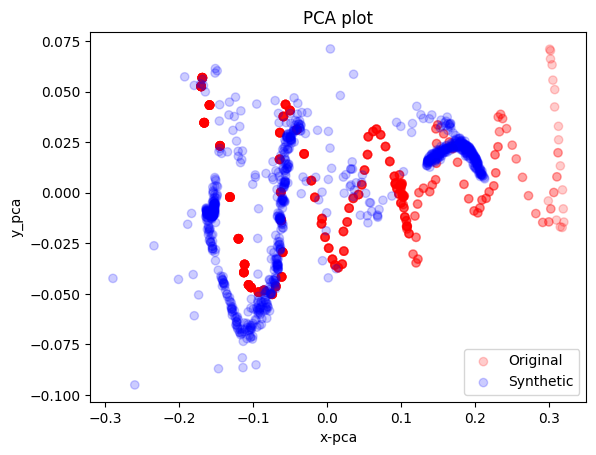

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1838 samples in 0.000s...
[t-SNE] Computed neighbors for 1838 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1838
[t-SNE] Computed conditional probabilities for sample 1838 / 1838
[t-SNE] Mean sigma: 0.015656
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.641682
[t-SNE] KL divergence after 300 iterations: 0.464388


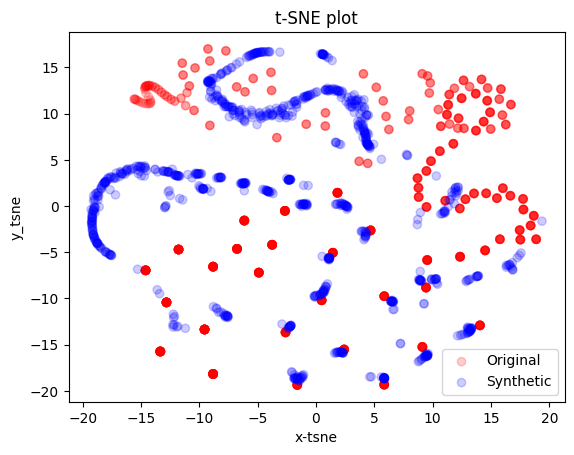

In [84]:
visualization(GOOG_processed_data,GOOG_genrated_data, 'pca')
visualization(GOOG_processed_data,GOOG_genrated_data, 'tsne')

vis of ori_stock


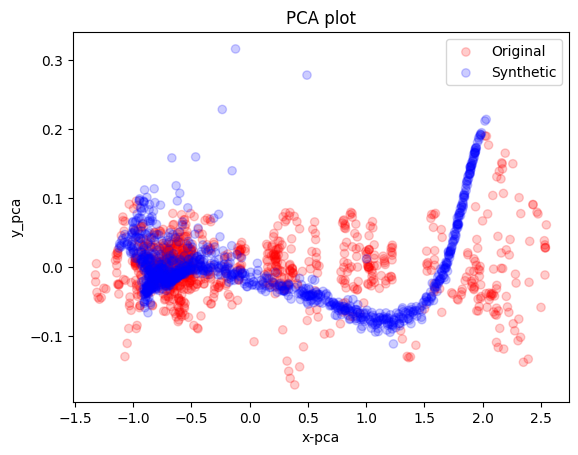

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.035023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.291069
[t-SNE] KL divergence after 300 iterations: 0.716086


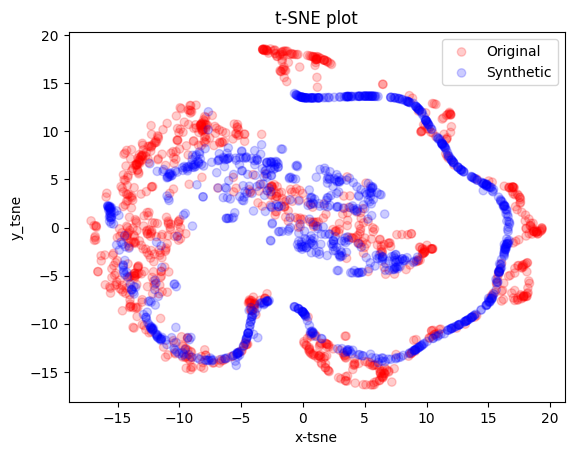

vis of group_data


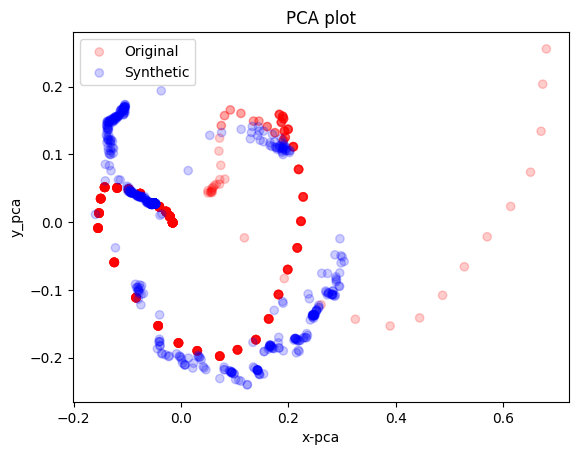

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1474 samples in 0.000s...
[t-SNE] Computed neighbors for 1474 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1474
[t-SNE] Computed conditional probabilities for sample 1474 / 1474
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.642956
[t-SNE] KL divergence after 300 iterations: 0.370412


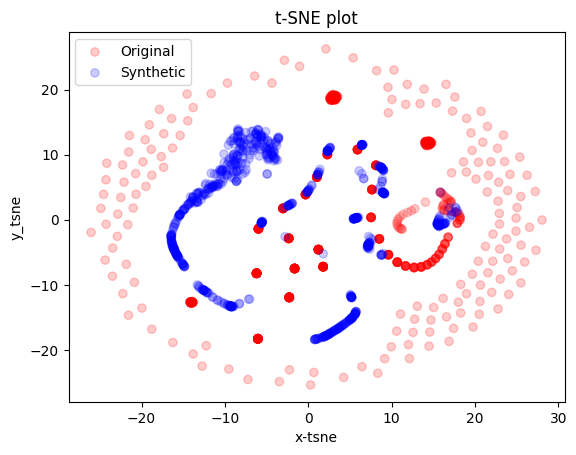

vis of single_data


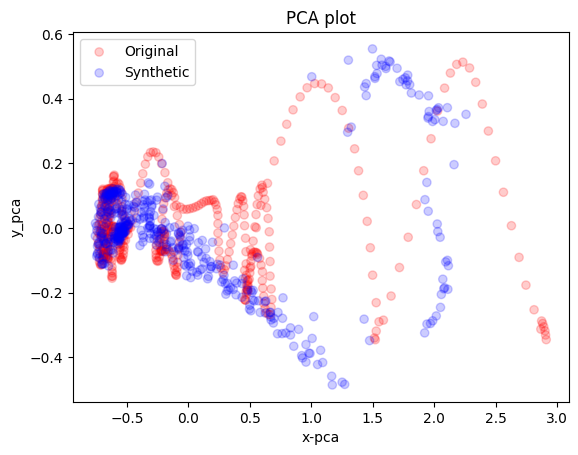

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 878 samples in 0.000s...
[t-SNE] Computed neighbors for 878 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 878 / 878
[t-SNE] Mean sigma: 0.071760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.651947
[t-SNE] KL divergence after 300 iterations: 0.514388


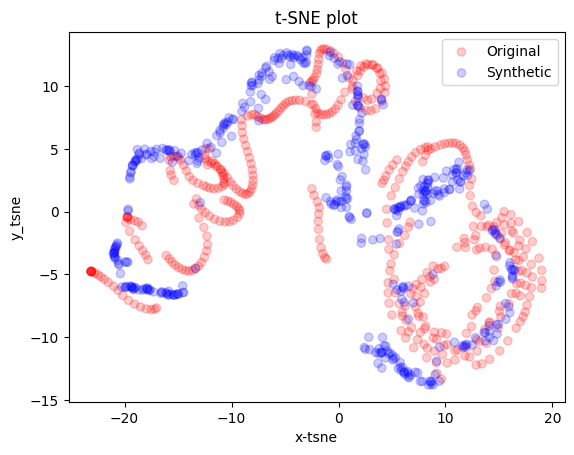

In [32]:
for k in data_dict.keys():
    print('vis of '+k)
    visualization(data_dict[k], generated_data_dict[k], 'pca')
    visualization(data_dict[k], generated_data_dict[k], 'tsne')

# Leverage Effect

In [21]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].pct_return.to_numpy()
        std=data_seg.std()
        std_list.append(std)
    return std_list

single stock

In [22]:
for tic in tics:
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv')
        print('stock',tic,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock AAPL regime 0


0
count  9.000000
mean   0.020886
std    0.005832
min    0.014411
25%    0.016206
50%    0.019266
75%    0.024828
max    0.029776

stock AAPL regime 1


0
count  17.000000
mean    0.017245
std     0.010832
min     0.007756
25%     0.010101
50%     0.016661
75%     0.017717
max     0.053692

stock AAPL regime 2


0
count  20.000000
mean    0.014343
std     0.002985
min     0.009344
25%     0.011940
50%     0.014121
75%     0.016689
max     0.020478

stock AMGN regime 0


0
count  10.000000
mean    0.018457
std     0.007132
min     0.008482
25%     0.014735
50%     0.018346
75%     0.020121
max     0.035298

stock AMGN regime 1


0
count  17.000000
mean    0.013193
std     0.003837
min     0.007035
25%     0.010569
50%     0.012758
75%     0.016803
max     0.019731

stock AMGN regime 2


0
count  18.000000
mean    0.014601
std     0.005595
min     0.008663
25%     0.011883
50%     0.012885
75%     0.014921
max     0.033364

stock AXP regime 0


0
count  7.000000
mean   0.024677
std    0.017537
min    0.013524
25%    0.014503
50%    0.017983
75%    0.024623
max    0.062980

stock AXP regime 1


0
count  14.000000
mean    0.013264
std     0.003123
min     0.008602
25%     0.011367
50%     0.013067
75%     0.014057
max     0.021121

stock AXP regime 2


0
count  13.000000
mean    0.017798
std     0.014756
min     0.006297
25%     0.010527
50%     0.011283
75%     0.015654
max     0.054664

stock BA regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock BA regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock BA regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

stock CAT regime 0


0
count  12.000000
mean    0.019207
std     0.006595
min     0.010924
25%     0.016305
50%     0.017977
75%     0.019243
max     0.038002

stock CAT regime 1


0
count  17.000000
mean    0.015225
std     0.005155
min     0.009853
25%     0.012382
50%     0.013752
75%     0.016417
max     0.031207

stock CAT regime 2


0
count  17.000000
mean    0.015252
std     0.004367
min     0.008396
25%     0.011758
50%     0.015776
75%     0.017079
max     0.024293

stock CRM regime 0


0
count  12.000000
mean    0.023008
std     0.008020
min     0.012316
25%     0.017586
50%     0.020573
75%     0.026596
max     0.041117

stock CRM regime 1


0
count  16.000000
mean    0.017630
std     0.006907
min     0.008040
25%     0.014099
50%     0.015094
75%     0.021482
max     0.036083

stock CRM regime 2


0
count  20.000000
mean    0.017953
std     0.006665
min     0.008195
25%     0.012943
50%     0.018631
75%     0.020530
max     0.036507

stock CSCO regime 0


0
count  9.000000
mean   0.020394
std    0.008696
min    0.012350
25%    0.015687
50%    0.018472
75%    0.020613
max    0.041375

stock CSCO regime 1


0
count  20.000000
mean    0.012910
std     0.003702
min     0.006808
25%     0.009928
50%     0.013023
75%     0.016519
max     0.017905

stock CSCO regime 2


0
count  19.000000
mean    0.014008
std     0.005992
min     0.007371
25%     0.009631
50%     0.012730
75%     0.015477
max     0.032123

stock CVX regime 0


0
count  9.000000
mean   0.018519
std    0.011985
min    0.008873
25%    0.011606
50%    0.014777
75%    0.018470
max    0.048028

stock CVX regime 1


0
count  19.000000
mean    0.012495
std     0.004883
min     0.007547
25%     0.008929
50%     0.011013
75%     0.015136
max     0.026123

stock CVX regime 2


0
count  14.000000
mean    0.016988
std     0.014404
min     0.006644
25%     0.009190
50%     0.011976
75%     0.018730
max     0.061690

stock DIS regime 0


0
count  6.000000
mean   0.019686
std    0.010352
min    0.010053
25%    0.013921
50%    0.015656
75%    0.022716
max    0.038341

stock DIS regime 1


0
count  15.000000
mean    0.011357
std     0.003864
min     0.007272
25%     0.008967
50%     0.010982
75%     0.012398
max     0.023682

stock DIS regime 2


0
count  17.000000
mean    0.014886
std     0.007895
min     0.007817
25%     0.009583
50%     0.011024
75%     0.018238
max     0.038246

stock GS regime 0


0
count  8.000000
mean   0.015862
std    0.003243
min    0.011987
25%    0.012963
50%    0.016125
75%    0.017656
max    0.020861

stock GS regime 1


0
count  18.000000
mean    0.014124
std     0.003141
min     0.009119
25%     0.012483
50%     0.013274
75%     0.016205
max     0.022705

stock GS regime 2


0
count  14.000000
mean    0.016079
std     0.007873
min     0.007386
25%     0.011814
50%     0.013994
75%     0.018577
max     0.039248

stock HD regime 0


0
count  6.000000
mean   0.013588
std    0.002935
min    0.010412
25%    0.011132
50%    0.013522
75%    0.015224
max    0.017947

stock HD regime 1


0
count  14.000000
mean    0.011409
std     0.003258
min     0.005691
25%     0.009383
50%     0.011984
75%     0.012549
max     0.018313

stock HD regime 2


0
count  17.000000
mean    0.011311
std     0.004157
min     0.005933
25%     0.008849
50%     0.010106
75%     0.012335
max     0.025105

stock HON regime 0


0
count  6.000000
mean   0.018851
std    0.009982
min    0.011725
25%    0.014647
50%    0.015071
75%    0.017188
max    0.038841

stock HON regime 1


0
count  15.000000
mean    0.011722
std     0.003849
min     0.006694
25%     0.009353
50%     0.010751
75%     0.013562
max     0.022448

stock HON regime 2


0
count  14.000000
mean    0.014191
std     0.007963
min     0.007350
25%     0.009491
50%     0.012002
75%     0.015277
max     0.038706

stock IBM regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock IBM regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock IBM regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock INTC regime 0


0
count  9.000000
mean   0.019607
std    0.005959
min    0.011808
25%    0.016794
50%    0.017270
75%    0.023452
max    0.030637

stock INTC regime 1


0
count  19.000000
mean    0.017721
std     0.011860
min     0.008906
25%     0.011959
50%     0.013236
75%     0.019605
max     0.061900

stock INTC regime 2


0
count  20.000000
mean    0.016157
std     0.004900
min     0.008471
25%     0.013351
50%     0.014784
75%     0.018353
max     0.027779

stock JNJ regime 0


0
count  3.000000
mean   0.025103
std    0.014495
min    0.011309
25%    0.017550
50%    0.023791
75%    0.032001
max    0.040210

stock JNJ regime 1


0
count  13.000000
mean    0.009092
std     0.002080
min     0.006035
25%     0.007894
50%     0.008919
75%     0.010071
max     0.013525

stock JNJ regime 2


0
count  9.000000
mean   0.009336
std    0.006063
min    0.005361
25%    0.005893
50%    0.007991
75%    0.008974
max    0.024854

stock JPM regime 0


0
count  7.000000
mean   0.015824
std    0.005064
min    0.008073
25%    0.012170
50%    0.017246
75%    0.019783
max    0.021541

stock JPM regime 1


0
count  23.000000
mean    0.013212
std     0.003814
min     0.007758
25%     0.011203
50%     0.012298
75%     0.013779
max     0.026322

stock JPM regime 2


0
count  21.000000
mean    0.013212
std     0.007471
min     0.006247
25%     0.009320
50%     0.012661
75%     0.013716
max     0.041648

stock KO regime 0


0
count  2.000000
mean   0.023115
std    0.024944
min    0.005477
25%    0.014296
50%    0.023115
75%    0.031934
max    0.040753

stock KO regime 1


0
count  8.000000
mean   0.011583
std    0.005955
min    0.006055
25%    0.008776
50%    0.009750
75%    0.011760
max    0.025162

stock KO regime 2


0
count  7.000000
mean   0.009796
std    0.003357
min    0.006646
25%    0.007227
50%    0.007996
75%    0.012066
max    0.015346

stock MCD regime 0


0
count  6.000000
mean   0.011296
std    0.003805
min    0.005854
25%    0.009939
50%    0.010927
75%    0.012549
max    0.017369

stock MCD regime 1


0
count  14.000000
mean    0.009387
std     0.002223
min     0.005603
25%     0.008299
50%     0.008799
75%     0.010520
max     0.014648

stock MCD regime 2


0
count  10.000000
mean    0.012681
std     0.008789
min     0.007032
25%     0.007582
50%     0.007956
75%     0.015536
max     0.035294

stock MMM regime 0


0
count  6.000000
mean   0.017538
std    0.004286
min    0.011715
25%    0.015600
50%    0.016772
75%    0.019685
max    0.024104

stock MMM regime 1


0
count  19.000000
mean    0.012554
std     0.009420
min     0.004704
25%     0.008195
50%     0.010561
75%     0.012778
max     0.049003

stock MMM regime 2


0
count  17.000000
mean    0.011215
std     0.004425
min     0.005575
25%     0.009531
50%     0.010696
75%     0.013040
max     0.023537

stock MRK regime 0


0
count  3.000000
mean   0.016784
std    0.004087
min    0.014200
25%    0.014428
50%    0.014655
75%    0.018076
max    0.021496

stock MRK regime 1


0
count  14.000000
mean    0.011313
std     0.003039
min     0.006341
25%     0.009878
50%     0.010909
75%     0.013411
max     0.016603

stock MRK regime 2


0
count  11.000000
mean    0.011679
std     0.003433
min     0.008438
25%     0.009684
50%     0.011112
75%     0.012252
max     0.020894

stock MSFT regime 0


0
count  6.000000
mean   0.025549
std    0.017804
min    0.010869
25%    0.015959
50%    0.021984
75%    0.023599
max    0.060369

stock MSFT regime 1


0
count  19.000000
mean    0.013887
std     0.003825
min     0.008238
25%     0.011369
50%     0.013130
75%     0.015203
max     0.021975

stock MSFT regime 2


0
count  15.000000
mean    0.013852
std     0.004734
min     0.007278
25%     0.011330
50%     0.012294
75%     0.014921
max     0.024934

stock NKE regime 0


0
count  9.000000
mean   0.014581
std    0.002907
min    0.011431
25%    0.012084
50%    0.014465
75%    0.015371
max    0.020282

stock NKE regime 1


0
count  20.000000
mean    0.014166
std     0.004296
min     0.008302
25%     0.011321
50%     0.012934
75%     0.017029
max     0.026094

stock NKE regime 2


0
count  18.000000
mean    0.016116
std     0.007128
min     0.007548
25%     0.012258
50%     0.013901
75%     0.017830
max     0.035638

stock PG regime 0


0
count  3.000000
mean   0.012125
std    0.001439
min    0.010929
25%    0.011327
50%    0.011725
75%    0.012723
max    0.013722

stock PG regime 1


0
count  13.000000
mean    0.010339
std     0.004781
min     0.005115
25%     0.008374
50%     0.009052
75%     0.009915
max     0.024338

stock PG regime 2


0
count  10.000000
mean    0.010131
std     0.003470
min     0.005038
25%     0.009115
50%     0.009633
75%     0.010328
max     0.018585

stock TRV regime 0


0
count  3.000000
mean   0.014911
std    0.002350
min    0.013524
25%    0.013555
50%    0.013586
75%    0.015605
max    0.017625

stock TRV regime 1


0
count  15.000000
mean    0.012086
std     0.006394
min     0.006138
25%     0.009611
50%     0.010185
75%     0.012594
max     0.033192

stock TRV regime 2


0
count  12.000000
mean    0.012519
std     0.006222
min     0.005832
25%     0.009488
50%     0.010987
75%     0.012483
max     0.026897

stock UNH regime 0


0
count  6.000000
mean   0.024183
std    0.019191
min    0.012270
25%    0.014071
50%    0.018859
75%    0.019607
max    0.062775

stock UNH regime 1


0
count  17.000000
mean    0.012867
std     0.003328
min     0.007100
25%     0.010705
50%     0.012346
75%     0.014815
max     0.020521

stock UNH regime 2


0
count  17.000000
mean    0.014800
std     0.008761
min     0.007611
25%     0.011917
50%     0.012493
75%     0.014221
max     0.045789

stock V regime 0


0
count  4.000000
mean   0.022324
std    0.013280
min    0.013264
25%    0.014120
50%    0.017131
75%    0.025335
max    0.041771

stock V regime 1


0
count  14.000000
mean    0.013458
std     0.003722
min     0.009598
25%     0.010751
50%     0.012039
75%     0.015251
max     0.023545

stock V regime 2


0
count  14.000000
mean    0.014268
std     0.007136
min     0.008029
25%     0.010477
50%     0.013195
75%     0.014505
max     0.036526

stock VZ regime 0


0
count  4.000000
mean   0.010043
std    0.001265
min    0.008178
25%    0.009893
50%    0.010501
75%    0.010651
max    0.010993

stock VZ regime 1


0
count  13.000000
mean    0.009880
std     0.002028
min     0.007410
25%     0.008679
50%     0.009388
75%     0.010611
max     0.013589

stock VZ regime 2


0
count  12.000000
mean    0.010440
std     0.002789
min     0.007630
25%     0.008132
50%     0.009550
75%     0.012455
max     0.015572

stock WBA regime 0


0
count  9.000000
mean   0.022262
std    0.006597
min    0.014130
25%    0.018390
50%    0.020482
75%    0.022977
max    0.035872

stock WBA regime 1


0
count  18.000000
mean    0.014984
std     0.006472
min     0.007156
25%     0.011358
50%     0.013401
75%     0.017917
max     0.036767

stock WBA regime 2


0
count  14.000000
mean    0.016176
std     0.005131
min     0.010139
25%     0.013413
50%     0.014585
75%     0.018646
max     0.029334

stock WMT regime 0


0
count  4.000000
mean   0.016112
std    0.006253
min    0.009454
25%    0.012207
50%    0.015550
75%    0.019456
max    0.023895

stock WMT regime 1


0
count  14.000000
mean    0.010104
std     0.001750
min     0.006695
25%     0.009303
50%     0.010270
75%     0.011120
max     0.013059

stock WMT regime 2


0
count  11.000000
mean    0.014393
std     0.009599
min     0.007177
25%     0.009215
50%     0.012513
75%     0.014283
max     0.041882

by stock group

In [23]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')
        print('stock',i,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock 0 regime 0


0
count  69.000000
mean    0.020105
std     0.011980
min     0.006847
25%     0.013403
50%     0.016698
75%     0.023791
max     0.067049

stock 0 regime 1


0
count  171.000000
mean     0.012485
std      0.005480
min      0.005115
25%      0.009293
50%      0.011299
75%      0.013559
max      0.053692

stock 0 regime 2


0
count  154.000000
mean     0.014259
std      0.008526
min      0.005038
25%      0.009588
50%      0.012082
75%      0.015621
max      0.061690

stock 1 regime 0


0
count  29.000000
mean    0.021239
std     0.015733
min     0.000575
25%     0.012693
50%     0.017133
75%     0.020818
max     0.062775

stock 1 regime 1


0
count  71.000000
mean    0.013268
std     0.003449
min     0.005691
25%     0.011043
50%     0.012773
75%     0.015203
max     0.022705

stock 1 regime 2


0
count  66.000000
mean    0.013889
std     0.006593
min     0.005933
25%     0.010920
50%     0.012315
75%     0.014381
max     0.045789

stock 2 regime 0


0
count  41.000000
mean    0.018817
std     0.008533
min     0.000693
25%     0.013287
50%     0.018390
75%     0.022643
max     0.041375

stock 2 regime 1


0
count  97.000000
mean    0.013470
std     0.006964
min     0.006055
25%     0.009790
50%     0.012163
75%     0.015842
max     0.061900

stock 2 regime 2


0
count  88.000000
mean    0.013562
std     0.005088
min     0.006646
25%     0.010072
50%     0.012872
75%     0.015347
max     0.032123

stock 3 regime 0


0
count  62.000000
mean    0.019403
std     0.008821
min     0.005854
25%     0.014461
50%     0.017516
75%     0.020580
max     0.051852

stock 3 regime 1


0
count  118.000000
mean     0.013290
std      0.005910
min      0.004704
25%      0.009846
50%      0.011998
75%      0.015015
max      0.049003

stock 3 regime 2


0
count  115.000000
mean     0.014257
std      0.006511
min      0.005569
25%      0.009927
50%      0.012684
75%      0.016127
max      0.038706

stock 4 regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock 4 regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock 4 regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock 5 regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock 5 regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock 5 regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

In [24]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

# key takeaway
1. regime 0 has high variance mean and high variance variance
2. regime 1 has low variance mean and low variance variance
3. regime 2 has low variance mean and low/high variance variance

# Pre-train Static learning classification discriminator

In [67]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

In [ ]:
def get_data_of_same_length_df(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [59]:
data=pd.read_csv('data_seg_'+"0"+'_'+"0"+'.csv')
display(data.columns)

Index(['Unnamed: 0', 'index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered'],
      dtype='object')

In [ ]:
for tic in tics:
    print(tic)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

ALL single stock classification have unbelieve 100% acc?

In [92]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1,use_multivariate='yes')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

stock_group 0
1.0
stock_group 1
1.0
stock_group 2
1.0
stock_group 3
1.0
stock_group 4
1.0
stock_group 5
1.0


Still 1.0?

In [48]:

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

# Pre-train Deep learning classification discriminator

### training

In [49]:
from tsai.all import *
my_setup()

os              : Linux-5.8.0-49-generic-x86_64-with-debian-bullseye-sid
python          : 3.7.15
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu117
device          : 4 gpus (['GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090'])
cpu cores       : 40
threads per cpu : 2
RAM             : 376.58 GB
GPU memory      : [23.7, 23.7, 23.7, 23.7] GB


stock_group 0


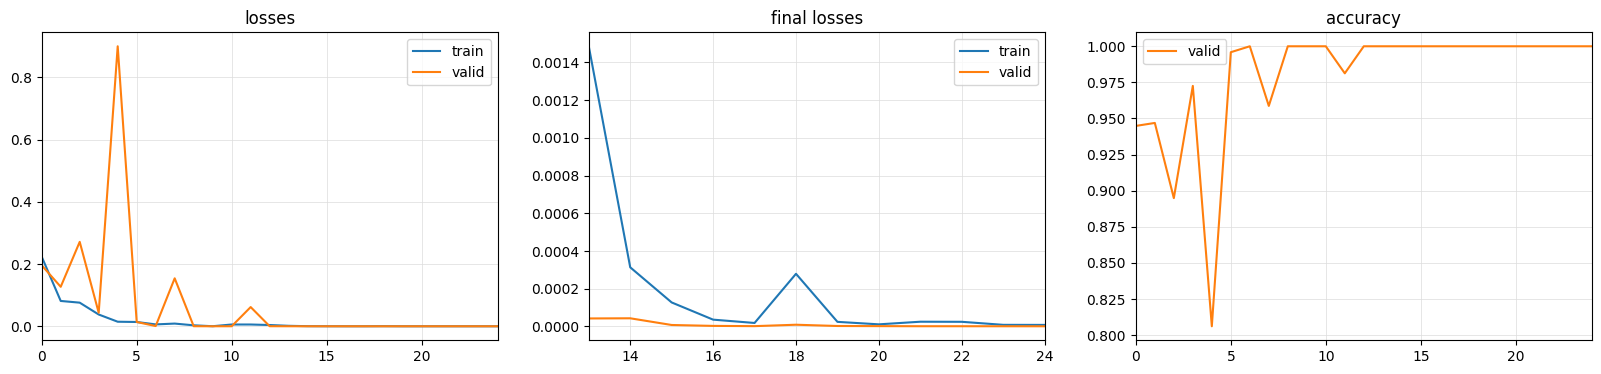

stock_group 1


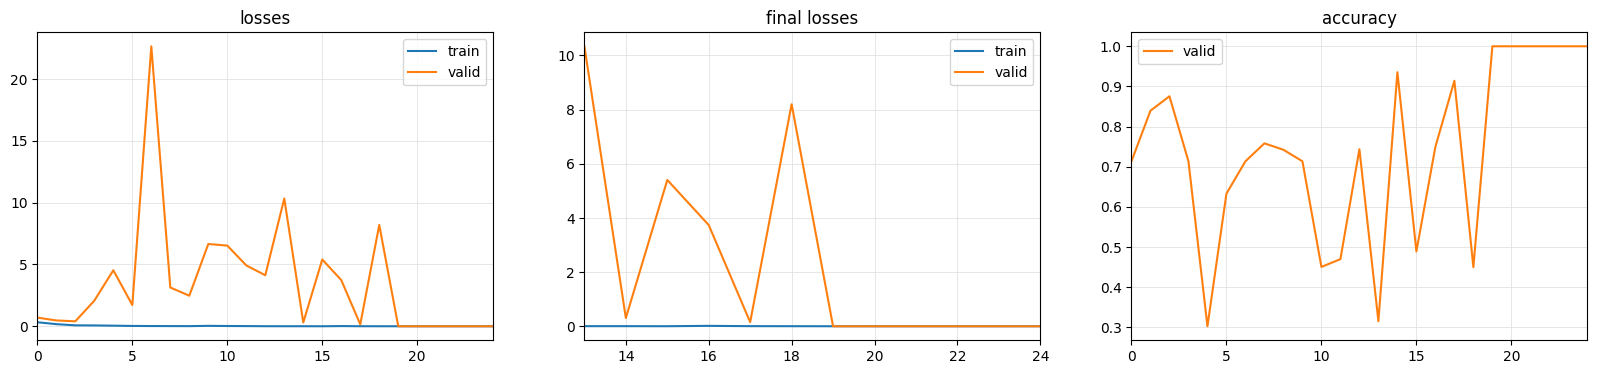

stock_group 2


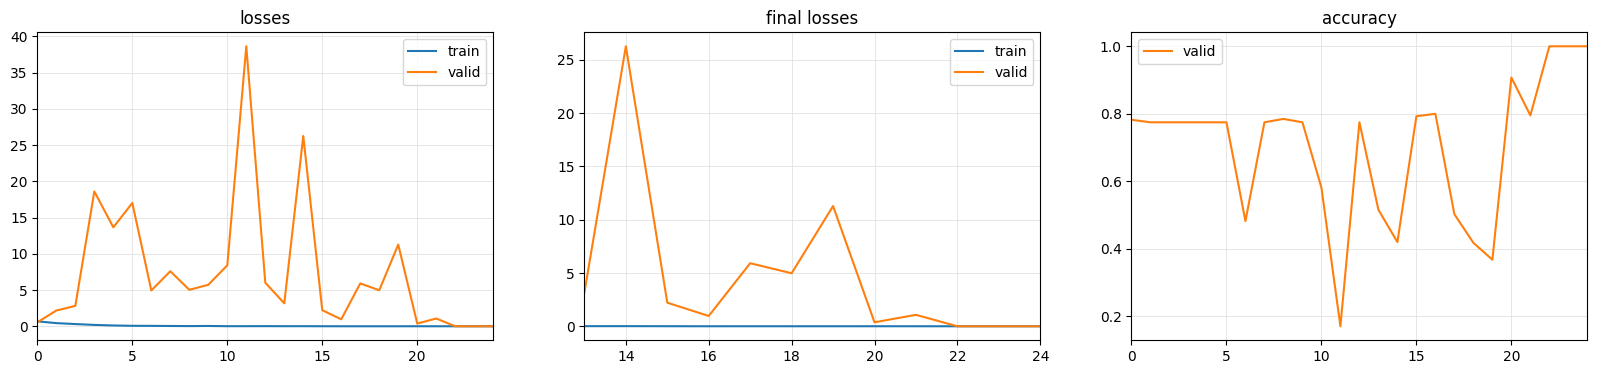

stock_group 3


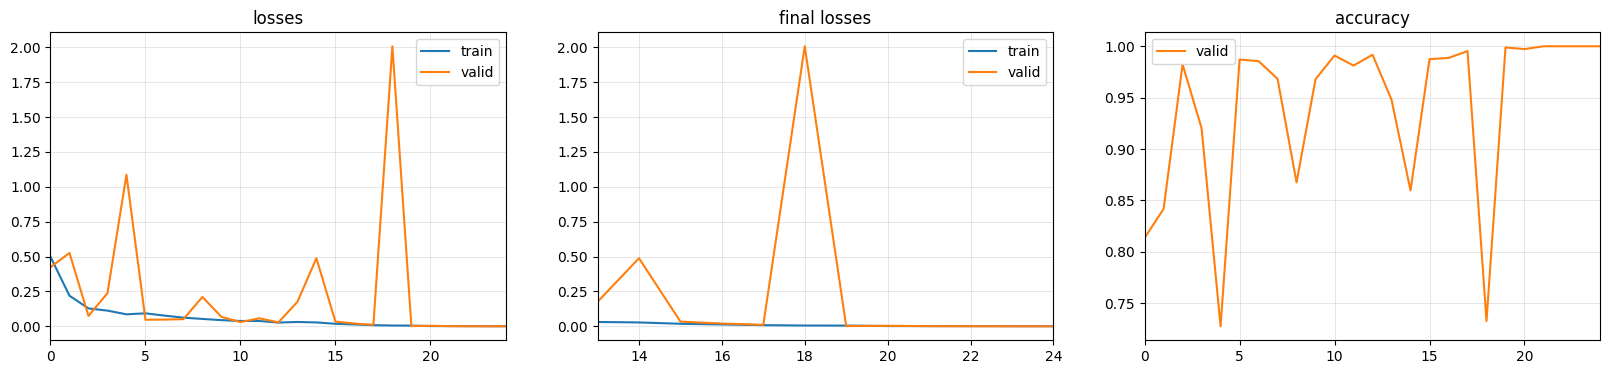

stock_group 4


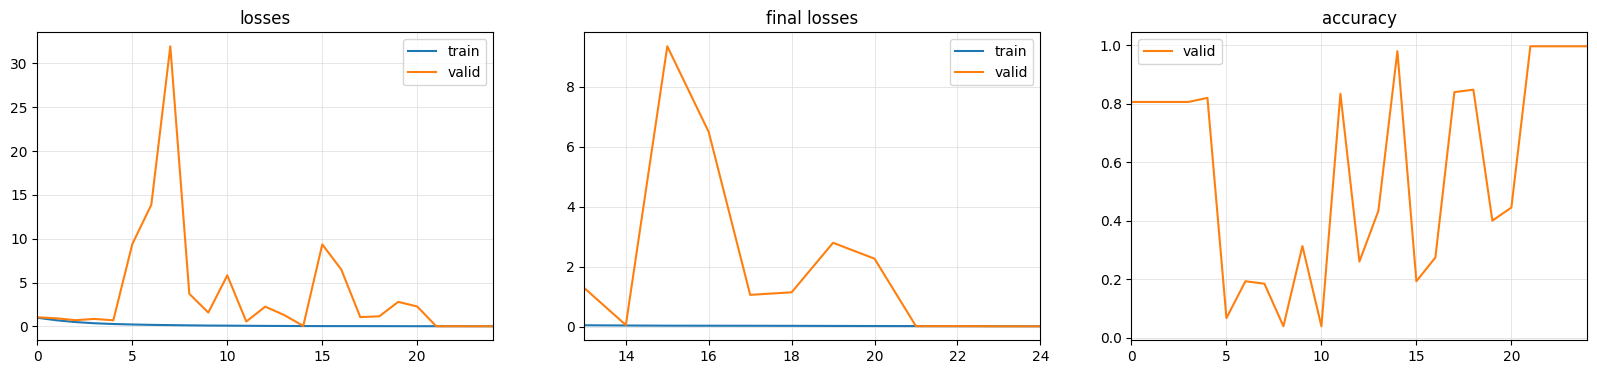

stock_group 5


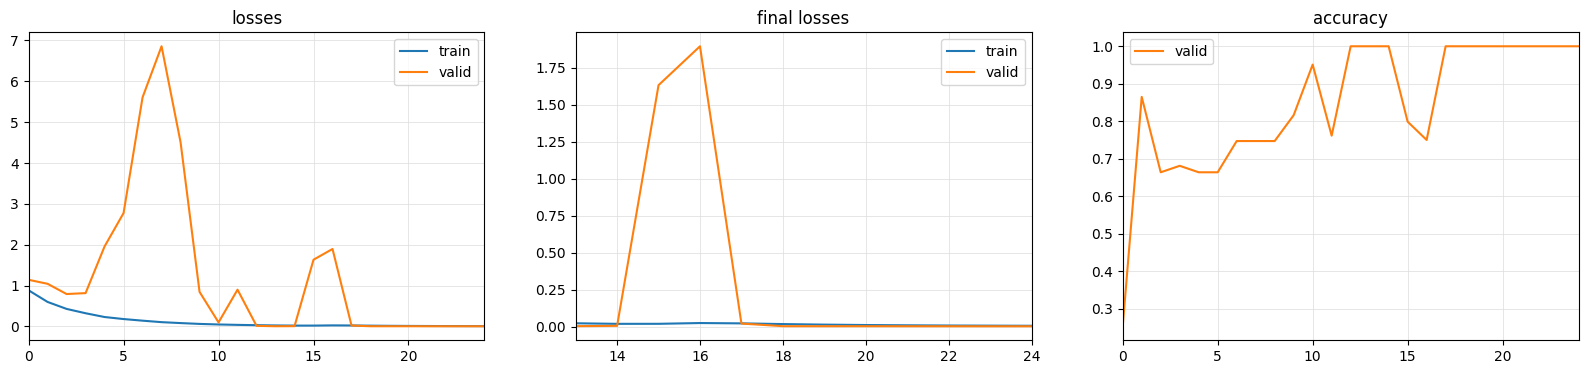

In [74]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length(data,24)
        label=np.full(len(process_data), j)
        X.extend([p.transpose() for p in process_data])
        y=np.concatenate((y, label), axis=0)
    X=np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(25, lr_max=1e-3)
    learn.plot_metrics()
    learn.save_all(path='export', dls_fname='dls_'+str(i)+'_'+str(j), model_fname='model_'+str(i)+'_'+str(j), learner_fname='learner_'+str(i)+'_'+str(j))
#     display(type(X_train),X_train.shape)

# Key takeaway

InceptionTime can do the job

In [50]:
X, y, splits = get_classification_data('LSST', split_data=False)

In [53]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

NameError: name 'new_y' is not defined

In [47]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

In [ ]:
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)
mv_clf.export("mv_clf.pkl")

## inference

## inference